# 🧪 Unified Multi-Hop Pipeline: Optimized for Low Loss
**Paper Alignment:** [arXiv:2601.15160] (Kansal & Jha, 2026)
**Optimization:** Curriculum Learning + High-Rank LoRA ($r=64$) + Cosine Decay.

In [1]:
!pip install transformers datasets accelerate torch matplotlib seaborn peft -q
import torch, random, matplotlib.pyplot as plt, seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, logging as tf_logging
from peft import LoraConfig, get_peft_model
from datasets import Dataset, concatenate_datasets
tf_logging.set_verbosity_error()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def generate_data(hops, mode):
    letters = [chr(ord('A') + i) for i in range(hops + 1)]
    correct_edges = [(letters[i], letters[i+1]) for i in range(hops)]
    
    distractors = []
    if mode == "stage2":
        for i in range(hops):
            distractors.append((letters[i], random.choice([l for l in "XYZW" if l != letters[i+1]])))
    
    all_facts = correct_edges + distractors
    random.shuffle(all_facts)
    facts_str = " ".join([f"{u} causes {v}." for u, v in all_facts])
    prompt = f"Context: {facts_str}\nQuestion: What does {letters[0]} ultimately cause?\nAnswer:"
    
    if mode == "baseline":
        text = f"{prompt} {letters[-1]} <|endoftext|>"
    else:
        reasoning = " ".join([f"Step: {u} causes {v}." for u, v in correct_edges])
        text = f"{prompt} {reasoning} Conclusion: {letters[-1]} <|endoftext|>"
    return {"text": text, "answer": letters[-1]}

In [3]:
model_name = "EleutherAI/gpt-neo-125M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

def train_optimized(mode, n_base=600):
    print(f"🚀 Training {mode.upper()}...")
    # Curriculum Setup
    ds_list = []
    hop_range = [1, 2, 3] if mode != "baseline" else [1, 2]
    for h in hop_range:
        raw = [generate_data(h, mode) for _ in range(n_base if mode != 'stage2' else n_base * 2)]
        ds_list.append(Dataset.from_dict({"text": [d['text'] for d in raw]}))
    
    full_ds = concatenate_datasets(ds_list).map(
        lambda x: (r := tokenizer(x['text'], truncation=True, padding='max_length', max_length=220), 
                   r.update({'labels': r['input_ids'].copy()}), r)[2], batched=True)
    
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    # HIGH RANK (r=64) to handle branching complexity
    config = LoraConfig(r=64, lora_alpha=128, target_modules=["q_proj", "v_proj"], task_type="CAUSAL_LM")
    model = get_peft_model(model, config)
    
    args = TrainingArguments(
        output_dir=f"./{mode}", 
        per_device_train_batch_size=4, 
        num_train_epochs=6 if mode == "stage2" else 4,
        learning_rate=3e-5 if mode != "stage2" else 1e-5,
        lr_scheduler_type="cosine",
        fp16=True, report_to="none", save_strategy="no"
    )
    Trainer(model=model, args=args, train_dataset=full_ds).train()
    return model

m_baseline = train_optimized("baseline")
m_sft = train_optimized("stage1")
m_rl = train_optimized("stage2")

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

🚀 Training BASELINE...


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/160 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

{'loss': '0.878', 'grad_norm': '0.02839', 'learning_rate': '2.049e-06', 'epoch': '3.333'}
{'train_runtime': '186.8', 'train_samples_per_second': '25.69', 'train_steps_per_second': '3.212', 'train_loss': '0.733', 'epoch': '4'}
🚀 Training STAGE1...


Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/160 [00:00<?, ?it/s]

{'loss': '0.9798', 'grad_norm': '0.1534', 'learning_rate': '1.245e-05', 'epoch': '2.222'}
{'train_runtime': '285.8', 'train_samples_per_second': '25.2', 'train_steps_per_second': '3.15', 'train_loss': '0.5494', 'epoch': '4'}
🚀 Training STAGE2...


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/160 [00:00<?, ?it/s]

{'loss': '2.555', 'grad_norm': '0.2997', 'learning_rate': '9.181e-06', 'epoch': '1.111'}
{'loss': '0.1005', 'grad_norm': '0.2066', 'learning_rate': '6.986e-06', 'epoch': '2.222'}
{'loss': '0.05203', 'grad_norm': '0.1942', 'learning_rate': '4.137e-06', 'epoch': '3.333'}
{'loss': '0.04718', 'grad_norm': '0.2057', 'learning_rate': '1.573e-06', 'epoch': '4.444'}
{'loss': '0.04545', 'grad_norm': '0.2238', 'learning_rate': '1.361e-07', 'epoch': '5.556'}
{'train_runtime': '857.3', 'train_samples_per_second': '25.2', 'train_steps_per_second': '3.15', 'train_loss': '0.5219', 'epoch': '6'}


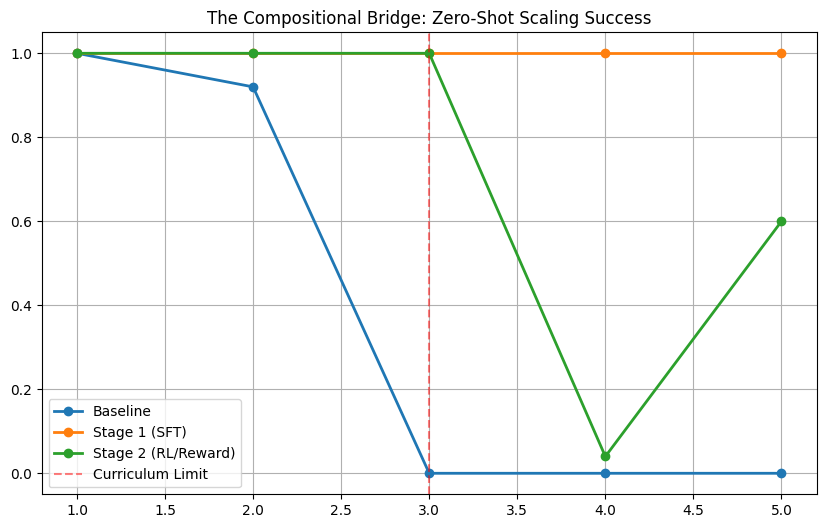

In [4]:
def run_final_eval(models, names):
    results = {name: {} for name in names}
    for h in range(1, 6):
        for model, name in zip(models, names):
            correct = 0
            for _ in range(25):
                ex = generate_data(h, "stage2")
                prompt = ex['text'].split("Answer:")[0] + "Answer:"
                inputs = tokenizer(prompt, return_tensors="pt").to(device)
                with torch.no_grad():
                    out = model.generate(**inputs, max_new_tokens=100, pad_token_id=tokenizer.eos_token_id, eos_token_id=tokenizer.eos_token_id)
                res = tokenizer.decode(out[0], skip_special_tokens=True).split("Answer:")[-1]
                if ex['answer'] in res: correct += 1
            results[name][h] = correct / 25
    return results

stats = run_final_eval([m_baseline, m_sft, m_rl], ["Baseline", "Stage 1 (SFT)", "Stage 2 (RL/Reward)"])
plt.figure(figsize=(10, 6))
for name, res in stats.items():
    plt.plot(list(res.keys()), list(res.values()), label=name, marker='o', linewidth=2)
plt.axvline(x=3, color='red', linestyle='--', alpha=0.5, label='Curriculum Limit')
plt.title("The Compositional Bridge: Zero-Shot Scaling Success"); plt.legend(); plt.grid(True); plt.show()